In [56]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats

#Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
#метрики и модели
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from category_encoders import TargetEncoder, CatBoostEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
#clustering
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import rand_score, jaccard_score, adjusted_mutual_info_score, silhouette_score
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN

In [34]:
test = pd.read_csv('/Users/andrei/repos/HousePricing/Data/test.csv')
train = pd.read_csv('/Users/andrei/repos/HousePricing/Data/train.csv')
submission = pd.read_csv('/Users/andrei/repos/HousePricing/Data/sample_submission.csv')

In [35]:
train['SalePrice'] = np.log1p(train['SalePrice'])
target = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

fdf = pd.concat([train_features, test_features]).reset_index(drop=True)
print(fdf.shape)

(2919, 80)


In [36]:
fdf['MSSubClass'] = fdf['MSSubClass'].apply(str)
fdf['YrSold'] = fdf['YrSold'].astype(str)
fdf['MoSold'] = fdf['MoSold'].astype(str)
fdf['OverallCond'] = fdf['OverallCond'].astype(str)

In [37]:
#Избавляемся от нулевых значений
nonelist = ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType')

zerolist = ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtHalfBath', 'BsmtFullBath', 'MasVnrArea')

for col in nonelist:
    fdf[col].fillna('None', inplace=True)
    
for col in zerolist:
    fdf[col].fillna(0, inplace=True)
    
fdf["LotFrontage"] = fdf.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

fdf['MSZoning'].fillna('RL', inplace=True)
fdf['Functional'].fillna('Typ', inplace=True)
fdf['Electrical'].fillna('SBrkr', inplace=True)
fdf['KitchenQual'].fillna('TA', inplace=True)
fdf['Exterior1st'].fillna('TA', inplace=True)
fdf['Exterior2nd'].fillna('TA', inplace=True)
fdf['SaleType'].fillna('WD', inplace=True)
fdf['Utilities'].fillna('AllPub', inplace=True)

In [38]:
fdf['TotalSF']=fdf['TotalBsmtSF'] + fdf['1stFlrSF'] + fdf['2ndFlrSF']

fdf['Total_Bathrooms'] = (fdf['FullBath'] + (0.5 * fdf['HalfBath']) +
                               fdf['BsmtFullBath'] + (0.5 * fdf['BsmtHalfBath']))

fdf['Total_porch_sf'] = (fdf['OpenPorchSF'] + fdf['3SsnPorch'] +
                              fdf['EnclosedPorch'] + fdf['ScreenPorch'] +
                              fdf['WoodDeckSF'])

fdf['haspool'] = fdf['PoolArea'].apply(lambda x: 1 if x > 0 else 0).apply(str)
fdf['has2ndfloor'] = fdf['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0).apply(str)
fdf['hasgarage'] = fdf['GarageArea'].apply(lambda x: 1 if x > 0 else 0).apply(str)
fdf['hasbsmt'] = fdf['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0).apply(str)
fdf['hasfireplace'] = fdf['Fireplaces'].apply(lambda x: 1 if x > 0 else 0).apply(str)

In [39]:
fdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 88 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2919 non-null   int64  
 1   MSSubClass       2919 non-null   object 
 2   MSZoning         2919 non-null   object 
 3   LotFrontage      2919 non-null   float64
 4   LotArea          2919 non-null   int64  
 5   Street           2919 non-null   object 
 6   Alley            2919 non-null   object 
 7   LotShape         2919 non-null   object 
 8   LandContour      2919 non-null   object 
 9   Utilities        2919 non-null   object 
 10  LotConfig        2919 non-null   object 
 11  LandSlope        2919 non-null   object 
 12  Neighborhood     2919 non-null   object 
 13  Condition1       2919 non-null   object 
 14  Condition2       2919 non-null   object 
 15  BldgType         2919 non-null   object 
 16  HouseStyle       2919 non-null   object 
 17  OverallQual   

In [40]:
cfdf = pd.concat([fdf[:1460], target], axis = 1)

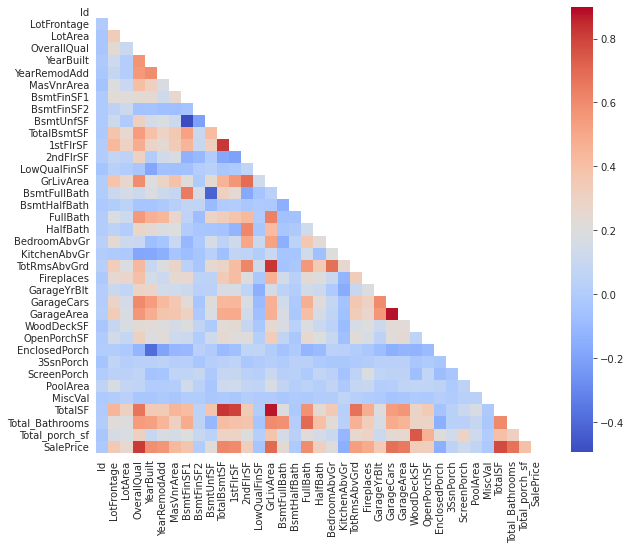

In [41]:
#Correlation map to understand how other features relate to SalePrice
corrmat = cfdf.corr()
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(corrmat, mask=mask, ax=ax, cbar_kws={"shrink": .82},vmax=.9, cmap='coolwarm', square=True)

In [98]:
corfeat = corrmat['SalePrice'][abs(corrmat['SalePrice']) >= 0.6].sort_values(ascending=False)

['OverallQual',
 'TotalSF',
 'GrLivArea',
 'GarageCars',
 'Total_Bathrooms',
 'GarageArea',
 'TotalBsmtSF']

In [100]:
clist.remove('SalePrice')

In [102]:
cldf = pd.DataFrame(fdf[clist])

In [110]:
scaler = StandardScaler()
scaledX = scaler.fit_transform(cldf)

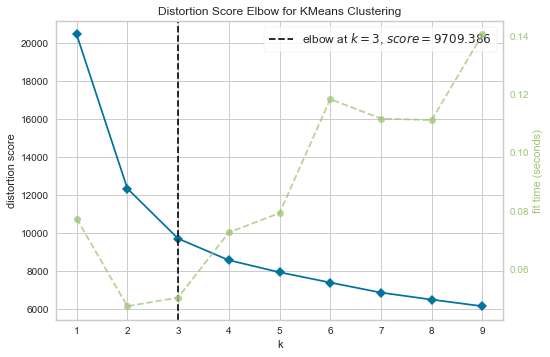

In [113]:
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
kmeans = KMeans(n_clusters=5)

vis_elbow = KElbowVisualizer(kmeans, k = (1, 10))
vis_elbow.fit(scaledX)
vis_elbow.poof();

In [180]:
clist

['OverallQual',
 'TotalSF',
 'GrLivArea',
 'GarageCars',
 'Total_Bathrooms',
 'GarageArea',
 'TotalBsmtSF']

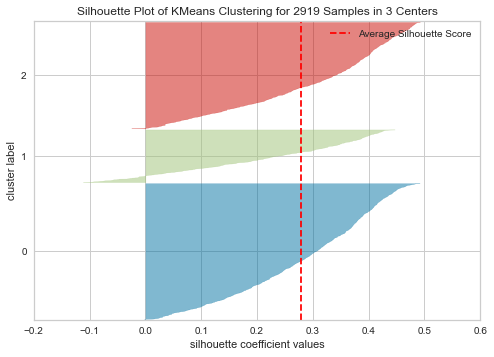

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2919 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [121]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
model = KMeans(3, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(scaledX)        # Fit the data to the visualizer
visualizer.show()  

In [122]:
cluster = KMeans(3, random_state=10)
cluster_labels = cluster.fit_predict(scaledX)

In [126]:
clustered_df = pd.concat([fdf, pd.DataFrame(cluster_labels)], axis = 1)

In [259]:
clustered_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleCondition,TotalSF,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,Cluster
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,Normal,2566.0,3.5,61,0,1,1,1,0,0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,Normal,2524.0,2.5,298,0,0,1,1,1,0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,Normal,2706.0,3.5,42,0,1,1,1,1,0
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,Abnorml,2473.0,2.0,307,0,1,1,1,1,0
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,Normal,3343.0,3.5,276,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,None,Reg,Lvl,AllPub,...,Normal,1638.0,1.5,0,0,1,0,1,0,2
2915,2916,160,RM,21.0,1894,Pave,None,Reg,Lvl,AllPub,...,Abnorml,1638.0,1.5,24,0,1,1,1,0,2
2916,2917,20,RL,160.0,20000,Pave,None,Reg,Lvl,AllPub,...,Abnorml,2448.0,2.0,474,0,0,1,1,1,0
2917,2918,85,RL,62.0,10441,Pave,None,Reg,Lvl,AllPub,...,Normal,1882.0,1.5,112,0,0,0,1,0,2


In [128]:
clustered_df.rename(columns={0:'Cluster'}, inplace=True)

In [132]:
clabels = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope' \
,'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl' \
,'Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual' \
,'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir' \
,'Electrical','KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual' \
,'GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','SaleType','SaleCondition']

In [134]:
cat_encoder = CatBoostEncoder(cols=clabels)
encoded_df = cat_encoder.fit_transform(clustered_df[:1460], target)


encoded_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleCondition,TotalSF,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,Cluster
0,1,12.024057,12.024057,65.0,8450,12.024057,12.024057,12.024057,12.024057,12.024057,...,12.024057,2566.0,3.5,61,0,1,1,1,0,0
1,2,12.024057,12.135878,80.0,9600,12.135878,12.135878,12.135878,12.135878,12.135878,...,12.135878,2524.0,2.5,298,0,0,1,1,1,0
2,3,12.135878,12.126924,68.0,11250,12.126924,12.126924,12.024057,12.126924,12.126924,...,12.126924,2706.0,3.5,42,0,1,1,1,1,0
3,4,12.024057,12.174486,60.0,9550,12.174486,12.174486,12.170614,12.174486,12.174486,...,12.024057,2473.0,2.0,307,0,1,1,1,1,0
4,5,12.196309,12.109470,84.0,14260,12.109470,12.109470,12.063544,12.109470,12.109470,...,12.174486,3343.0,3.5,276,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,12.339817,12.085700,62.0,7917,12.025211,12.037380,11.935212,12.022340,12.023869,...,12.004586,2600.0,2.5,40,0,1,1,1,1,0
1456,1457,12.052998,12.085689,85.0,13175,12.025244,12.037406,11.935361,12.022378,12.023903,...,12.004643,3615.0,3.0,349,0,0,1,1,1,1
1457,1458,11.956234,12.085836,66.0,9042,12.025402,12.037565,11.935707,12.022556,12.024061,...,12.004852,3492.0,2.0,60,0,1,1,1,1,0
1458,1459,12.053375,12.086190,68.0,9717,12.025724,12.037898,11.936311,12.022915,12.024383,...,12.005260,2156.0,2.0,478,0,0,1,1,0,2


In [135]:
test_encoded = cat_encoder.transform(clustered_df[1460:])

In [136]:
scaler = StandardScaler()
scaledX = scaler.fit_transform(encoded_df)
scaledtest = scaler.transform(test_encoded)

xtrain, xvalid, ytrain, yvalid = train_test_split(scaledX, target, test_size = 0.25)

In [137]:
cbm = CatBoostRegressor(depth=4, iterations=2000, learning_rate=0.05)
cbm.fit(xtrain, ytrain)

0:	learn: 0.3799646	total: 63.1ms	remaining: 2m 6s
1:	learn: 0.3684251	total: 66.5ms	remaining: 1m 6s
2:	learn: 0.3568248	total: 69.4ms	remaining: 46.2s
3:	learn: 0.3453459	total: 72.2ms	remaining: 36s
4:	learn: 0.3348408	total: 75.8ms	remaining: 30.2s
5:	learn: 0.3253446	total: 78.3ms	remaining: 26s
6:	learn: 0.3158476	total: 80.6ms	remaining: 22.9s
7:	learn: 0.3071434	total: 82.9ms	remaining: 20.6s
8:	learn: 0.2984119	total: 85.2ms	remaining: 18.8s
9:	learn: 0.2903836	total: 87.5ms	remaining: 17.4s
10:	learn: 0.2831566	total: 89.8ms	remaining: 16.2s
11:	learn: 0.2766494	total: 92.1ms	remaining: 15.3s
12:	learn: 0.2706424	total: 94.5ms	remaining: 14.4s
13:	learn: 0.2637243	total: 96.8ms	remaining: 13.7s
14:	learn: 0.2572899	total: 99.2ms	remaining: 13.1s
15:	learn: 0.2514789	total: 102ms	remaining: 12.6s
16:	learn: 0.2451378	total: 104ms	remaining: 12.1s
17:	learn: 0.2393318	total: 106ms	remaining: 11.7s
18:	learn: 0.2339670	total: 109ms	remaining: 11.3s
19:	learn: 0.2288464	total: 11

199:	learn: 0.0973236	total: 634ms	remaining: 5.7s
200:	learn: 0.0971158	total: 636ms	remaining: 5.69s
201:	learn: 0.0968856	total: 638ms	remaining: 5.68s
202:	learn: 0.0966205	total: 643ms	remaining: 5.69s
203:	learn: 0.0964381	total: 647ms	remaining: 5.69s
204:	learn: 0.0962368	total: 652ms	remaining: 5.71s
205:	learn: 0.0960466	total: 654ms	remaining: 5.7s
206:	learn: 0.0959222	total: 657ms	remaining: 5.69s
207:	learn: 0.0957674	total: 661ms	remaining: 5.69s
208:	learn: 0.0957016	total: 664ms	remaining: 5.69s
209:	learn: 0.0955373	total: 666ms	remaining: 5.68s
210:	learn: 0.0954015	total: 668ms	remaining: 5.67s
211:	learn: 0.0952866	total: 671ms	remaining: 5.66s
212:	learn: 0.0951678	total: 675ms	remaining: 5.66s
213:	learn: 0.0949014	total: 677ms	remaining: 5.65s
214:	learn: 0.0947223	total: 679ms	remaining: 5.64s
215:	learn: 0.0945394	total: 682ms	remaining: 5.63s
216:	learn: 0.0943661	total: 684ms	remaining: 5.62s
217:	learn: 0.0942811	total: 686ms	remaining: 5.61s
218:	learn: 0.

398:	learn: 0.0726213	total: 1.39s	remaining: 5.59s
399:	learn: 0.0725027	total: 1.41s	remaining: 5.65s
400:	learn: 0.0723955	total: 1.42s	remaining: 5.67s
401:	learn: 0.0723372	total: 1.43s	remaining: 5.68s
402:	learn: 0.0722502	total: 1.43s	remaining: 5.68s
403:	learn: 0.0721177	total: 1.44s	remaining: 5.69s
404:	learn: 0.0720550	total: 1.45s	remaining: 5.69s
405:	learn: 0.0719518	total: 1.45s	remaining: 5.68s
406:	learn: 0.0718991	total: 1.46s	remaining: 5.7s
407:	learn: 0.0717971	total: 1.46s	remaining: 5.7s
408:	learn: 0.0717124	total: 1.46s	remaining: 5.7s
409:	learn: 0.0716063	total: 1.47s	remaining: 5.7s
410:	learn: 0.0715337	total: 1.48s	remaining: 5.71s
411:	learn: 0.0714984	total: 1.48s	remaining: 5.71s
412:	learn: 0.0714120	total: 1.49s	remaining: 5.71s
413:	learn: 0.0713871	total: 1.49s	remaining: 5.71s
414:	learn: 0.0713183	total: 1.49s	remaining: 5.71s
415:	learn: 0.0712141	total: 1.5s	remaining: 5.71s
416:	learn: 0.0711549	total: 1.51s	remaining: 5.72s
417:	learn: 0.071

594:	learn: 0.0589986	total: 2.35s	remaining: 5.54s
595:	learn: 0.0589531	total: 2.35s	remaining: 5.53s
596:	learn: 0.0589392	total: 2.35s	remaining: 5.53s
597:	learn: 0.0588402	total: 2.35s	remaining: 5.52s
598:	learn: 0.0588230	total: 2.36s	remaining: 5.51s
599:	learn: 0.0587392	total: 2.36s	remaining: 5.51s
600:	learn: 0.0586388	total: 2.36s	remaining: 5.5s
601:	learn: 0.0585618	total: 2.37s	remaining: 5.49s
602:	learn: 0.0584942	total: 2.37s	remaining: 5.49s
603:	learn: 0.0584403	total: 2.37s	remaining: 5.48s
604:	learn: 0.0583593	total: 2.37s	remaining: 5.47s
605:	learn: 0.0582774	total: 2.38s	remaining: 5.47s
606:	learn: 0.0582560	total: 2.38s	remaining: 5.46s
607:	learn: 0.0582060	total: 2.38s	remaining: 5.45s
608:	learn: 0.0581866	total: 2.38s	remaining: 5.45s
609:	learn: 0.0581449	total: 2.39s	remaining: 5.44s
610:	learn: 0.0580876	total: 2.39s	remaining: 5.44s
611:	learn: 0.0580241	total: 2.39s	remaining: 5.43s
612:	learn: 0.0579314	total: 2.4s	remaining: 5.42s
613:	learn: 0.

820:	learn: 0.0478360	total: 2.91s	remaining: 4.18s
821:	learn: 0.0477897	total: 2.92s	remaining: 4.18s
822:	learn: 0.0477090	total: 2.92s	remaining: 4.18s
823:	learn: 0.0476609	total: 2.92s	remaining: 4.17s
824:	learn: 0.0476458	total: 2.92s	remaining: 4.17s
825:	learn: 0.0475900	total: 2.93s	remaining: 4.16s
826:	learn: 0.0475864	total: 2.93s	remaining: 4.16s
827:	learn: 0.0475628	total: 2.93s	remaining: 4.15s
828:	learn: 0.0475556	total: 2.94s	remaining: 4.15s
829:	learn: 0.0475120	total: 2.94s	remaining: 4.14s
830:	learn: 0.0474486	total: 2.94s	remaining: 4.14s
831:	learn: 0.0473981	total: 2.94s	remaining: 4.13s
832:	learn: 0.0473465	total: 2.95s	remaining: 4.13s
833:	learn: 0.0472659	total: 2.95s	remaining: 4.13s
834:	learn: 0.0472255	total: 2.95s	remaining: 4.12s
835:	learn: 0.0471759	total: 2.96s	remaining: 4.12s
836:	learn: 0.0471321	total: 2.96s	remaining: 4.11s
837:	learn: 0.0471248	total: 2.96s	remaining: 4.11s
838:	learn: 0.0470536	total: 2.97s	remaining: 4.1s
839:	learn: 0

1034:	learn: 0.0394699	total: 3.48s	remaining: 3.25s
1035:	learn: 0.0394318	total: 3.48s	remaining: 3.24s
1036:	learn: 0.0394264	total: 3.49s	remaining: 3.24s
1037:	learn: 0.0393843	total: 3.49s	remaining: 3.23s
1038:	learn: 0.0393402	total: 3.49s	remaining: 3.23s
1039:	learn: 0.0393069	total: 3.5s	remaining: 3.23s
1040:	learn: 0.0392732	total: 3.5s	remaining: 3.22s
1041:	learn: 0.0392331	total: 3.5s	remaining: 3.22s
1042:	learn: 0.0391855	total: 3.5s	remaining: 3.21s
1043:	learn: 0.0391819	total: 3.51s	remaining: 3.21s
1044:	learn: 0.0391476	total: 3.51s	remaining: 3.21s
1045:	learn: 0.0390991	total: 3.51s	remaining: 3.2s
1046:	learn: 0.0390955	total: 3.51s	remaining: 3.2s
1047:	learn: 0.0390510	total: 3.52s	remaining: 3.19s
1048:	learn: 0.0389915	total: 3.52s	remaining: 3.19s
1049:	learn: 0.0389364	total: 3.52s	remaining: 3.19s
1050:	learn: 0.0389268	total: 3.52s	remaining: 3.18s
1051:	learn: 0.0389008	total: 3.53s	remaining: 3.18s
1052:	learn: 0.0388542	total: 3.53s	remaining: 3.17s

1252:	learn: 0.0332052	total: 4.05s	remaining: 2.42s
1253:	learn: 0.0331692	total: 4.06s	remaining: 2.41s
1254:	learn: 0.0331611	total: 4.06s	remaining: 2.41s
1255:	learn: 0.0331341	total: 4.06s	remaining: 2.41s
1256:	learn: 0.0331312	total: 4.06s	remaining: 2.4s
1257:	learn: 0.0331014	total: 4.07s	remaining: 2.4s
1258:	learn: 0.0330648	total: 4.07s	remaining: 2.4s
1259:	learn: 0.0330090	total: 4.07s	remaining: 2.39s
1260:	learn: 0.0329792	total: 4.07s	remaining: 2.39s
1261:	learn: 0.0329773	total: 4.08s	remaining: 2.38s
1262:	learn: 0.0329643	total: 4.08s	remaining: 2.38s
1263:	learn: 0.0329587	total: 4.08s	remaining: 2.38s
1264:	learn: 0.0329559	total: 4.08s	remaining: 2.37s
1265:	learn: 0.0329133	total: 4.09s	remaining: 2.37s
1266:	learn: 0.0328794	total: 4.09s	remaining: 2.37s
1267:	learn: 0.0328467	total: 4.09s	remaining: 2.36s
1268:	learn: 0.0328125	total: 4.09s	remaining: 2.36s
1269:	learn: 0.0328094	total: 4.09s	remaining: 2.35s
1270:	learn: 0.0327755	total: 4.1s	remaining: 2.3

1415:	learn: 0.0293289	total: 4.43s	remaining: 1.83s
1416:	learn: 0.0293017	total: 4.43s	remaining: 1.82s
1417:	learn: 0.0292794	total: 4.44s	remaining: 1.82s
1418:	learn: 0.0292464	total: 4.44s	remaining: 1.82s
1419:	learn: 0.0292180	total: 4.44s	remaining: 1.81s
1420:	learn: 0.0292102	total: 4.44s	remaining: 1.81s
1421:	learn: 0.0291904	total: 4.45s	remaining: 1.81s
1422:	learn: 0.0291560	total: 4.45s	remaining: 1.8s
1423:	learn: 0.0291329	total: 4.45s	remaining: 1.8s
1424:	learn: 0.0291161	total: 4.45s	remaining: 1.8s
1425:	learn: 0.0291012	total: 4.46s	remaining: 1.79s
1426:	learn: 0.0290941	total: 4.46s	remaining: 1.79s
1427:	learn: 0.0290654	total: 4.46s	remaining: 1.79s
1428:	learn: 0.0290464	total: 4.46s	remaining: 1.78s
1429:	learn: 0.0290330	total: 4.47s	remaining: 1.78s
1430:	learn: 0.0290185	total: 4.47s	remaining: 1.78s
1431:	learn: 0.0289615	total: 4.47s	remaining: 1.77s
1432:	learn: 0.0289279	total: 4.47s	remaining: 1.77s
1433:	learn: 0.0289264	total: 4.47s	remaining: 1.

1571:	learn: 0.0259184	total: 4.82s	remaining: 1.31s
1572:	learn: 0.0259174	total: 4.82s	remaining: 1.31s
1573:	learn: 0.0259023	total: 4.82s	remaining: 1.3s
1574:	learn: 0.0258867	total: 4.83s	remaining: 1.3s
1575:	learn: 0.0258559	total: 4.83s	remaining: 1.3s
1576:	learn: 0.0258236	total: 4.83s	remaining: 1.3s
1577:	learn: 0.0257896	total: 4.84s	remaining: 1.29s
1578:	learn: 0.0257718	total: 4.84s	remaining: 1.29s
1579:	learn: 0.0257370	total: 4.84s	remaining: 1.29s
1580:	learn: 0.0257075	total: 4.84s	remaining: 1.28s
1581:	learn: 0.0256888	total: 4.85s	remaining: 1.28s
1582:	learn: 0.0256578	total: 4.85s	remaining: 1.28s
1583:	learn: 0.0256218	total: 4.85s	remaining: 1.27s
1584:	learn: 0.0256010	total: 4.86s	remaining: 1.27s
1585:	learn: 0.0255610	total: 4.86s	remaining: 1.27s
1586:	learn: 0.0255422	total: 4.86s	remaining: 1.26s
1587:	learn: 0.0255416	total: 4.86s	remaining: 1.26s
1588:	learn: 0.0255067	total: 4.87s	remaining: 1.26s
1589:	learn: 0.0254886	total: 4.87s	remaining: 1.2

1731:	learn: 0.0225936	total: 5.2s	remaining: 805ms
1732:	learn: 0.0225858	total: 5.21s	remaining: 802ms
1733:	learn: 0.0225745	total: 5.21s	remaining: 799ms
1734:	learn: 0.0225669	total: 5.21s	remaining: 796ms
1735:	learn: 0.0225629	total: 5.21s	remaining: 793ms
1736:	learn: 0.0225374	total: 5.21s	remaining: 790ms
1737:	learn: 0.0225041	total: 5.22s	remaining: 786ms
1738:	learn: 0.0224828	total: 5.22s	remaining: 783ms
1739:	learn: 0.0224657	total: 5.22s	remaining: 780ms
1740:	learn: 0.0224456	total: 5.22s	remaining: 777ms
1741:	learn: 0.0224256	total: 5.23s	remaining: 774ms
1742:	learn: 0.0224176	total: 5.23s	remaining: 771ms
1743:	learn: 0.0224071	total: 5.23s	remaining: 768ms
1744:	learn: 0.0223999	total: 5.23s	remaining: 765ms
1745:	learn: 0.0223785	total: 5.24s	remaining: 762ms
1746:	learn: 0.0223395	total: 5.24s	remaining: 758ms
1747:	learn: 0.0223384	total: 5.24s	remaining: 755ms
1748:	learn: 0.0223211	total: 5.24s	remaining: 752ms
1749:	learn: 0.0222961	total: 5.24s	remaining: 

1899:	learn: 0.0199687	total: 5.59s	remaining: 294ms
1900:	learn: 0.0199530	total: 5.59s	remaining: 291ms
1901:	learn: 0.0199363	total: 5.59s	remaining: 288ms
1902:	learn: 0.0199283	total: 5.59s	remaining: 285ms
1903:	learn: 0.0199011	total: 5.59s	remaining: 282ms
1904:	learn: 0.0198705	total: 5.6s	remaining: 279ms
1905:	learn: 0.0198553	total: 5.6s	remaining: 276ms
1906:	learn: 0.0198475	total: 5.6s	remaining: 273ms
1907:	learn: 0.0198369	total: 5.6s	remaining: 270ms
1908:	learn: 0.0198195	total: 5.61s	remaining: 267ms
1909:	learn: 0.0198055	total: 5.61s	remaining: 264ms
1910:	learn: 0.0197799	total: 5.61s	remaining: 261ms
1911:	learn: 0.0197793	total: 5.61s	remaining: 258ms
1912:	learn: 0.0197638	total: 5.62s	remaining: 255ms
1913:	learn: 0.0197631	total: 5.62s	remaining: 252ms
1914:	learn: 0.0197623	total: 5.62s	remaining: 250ms
1915:	learn: 0.0197606	total: 5.62s	remaining: 247ms
1916:	learn: 0.0197550	total: 5.63s	remaining: 244ms
1917:	learn: 0.0197451	total: 5.63s	remaining: 241

In [138]:
testresult = np.expm1(cbm.predict(scaledtest))

In [148]:
t = pd.concat([test, pd.DataFrame(testresult)], axis=1)

In [152]:
t.rename(columns={0:'SalePrice'}, inplace=True)

In [153]:
t[['Id', 'SalePrice']].to_csv('submission.csv', sep=',', index=False)